## <center>Практическая часть<a class="anchor" id="practice"></a><center>

### Постановка задачи<a class="anchor" id="task"></a>

**Задача**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту, используя обучающий датасет. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.


### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета +
2. Обработка пропусков +
3. Обработка выбросов +
4. Анализ данных +
5. Отбор признаков 
6. Балансировка классов 
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

In [371]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

# Нормализация данных
from sklearn.preprocessing import StandardScaler

# Балансировка целевой переменной
# !pip install imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Индикатор пропущенных значений
from sklearn.impute import MissingIndicator 

# алгоритм заполнения пропусков по К-ближайшим соседям 
from sklearn.impute import KNNImputer

from scipy.stats import shapiro, probplot, mannwhitneyu

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb 
import catboost as catb

# import lightgbm as lgbm

In [372]:
import warnings
warnings.simplefilter('ignore')

**Пути к директориям и файлам**

In [373]:
#input
DATASET_PATH = 'course_project/course_project_train.csv'

#output
PREP_DATASET_PATH = 'course_project/course_project_test.csv'


### Функции

In [374]:

# Балансировка классов

def balance_df_by_target(data, target_name, method):
    
    assert method in ['RandomOverSampler',  # OverSampling
                      'RandomUnderSampler'] # UnderSampling
                
    target_counts = data[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    
    if method == 'RandomOverSampler':
        X_RandomOverSampler, y_RandomOverSampler = RandomOverSampler().fit_sample(data.drop(columns=target_name), 
                                                                                  data[target_name])
        data = pd.concat([X_RandomOverSampler, y_RandomOverSampler], axis=1)

    elif method == 'RandomUnderSampler':
        X_RandomUnderSampler, y_RandomUnderSampler = RandomUnderSampler().fit_sample(data.drop(columns=target_name), 
                                                                                     data[target_name])
        data = pd.concat([X_RandomUnderSampler, y_RandomUnderSampler], axis=1)

    return data.sample(frac=1) 
    

In [375]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [376]:
def transform(data):
    
    for colname in CAT_FEATURE_NAMES:
        data[colname] = data[colname].astype(str)
        
    # Объединим наличие кредитов на ипотеку и дом в ипотеке.    
    data.loc[data['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
    
    # Объединим схожие цели кредитов.
    # путешествия и отдых
    data.loc[data['Purpose'] == 'vacation', 'Purpose'] = 'take a trip' 
    # малый бизнес и заем на бизнес
    data.loc[data['Purpose'] == 'small business', 'Purpose'] = 'business loan'
    # возобновляемая энергия и прочее
    data.loc[data['Purpose'] == 'renewable energy', 'Purpose'] = 'other'
    
    # корректировка значений для перевода в некатегориальный признак
    dict_years_in_current_job = {'nan': np.NaN, 
                             '< 1 year': 0.5,
                             '1 year': 1,
                             '2 years': 2,
                             '3 years': 3,
                             '4 years': 4,
                             '5 years': 5,
                             '6 years': 6,
                             '7 years': 7,
                             '8 years': 8,
                             '9 years': 9,
                             '10+ years': 10}
    data['Years in current job'].replace(dict_years_in_current_job, inplace=True)
    
    # добавим индикатор к пропущенным значениям
    mi = MissingIndicator()
    mi.fit_transform(data)
    
    # Введем новую фичу 'Annual Income Unknown' (годовой доход известный - 0, годовой доход неизвестный - 1)
    data['Annual Income Unknown'] = 0
    data.loc[(data['Annual Income'].isnull()), 'Annual Income Unknown'] = 1
    
    # Введем новую фичу 'Bad Background' (0 - проблем не было, 1 - небольшие проблемы, 2 - проблемы и банкротства)
    data['Bad Background'] = True
    data.loc[data['Number of Credit Problems'] > 0 , 'Bad Background'] = 1
    data.loc[data['Bankruptcies'] > 0 , 'Bad Background'] = 2
    data.loc[data['Number of Credit Problems'] == 0, 'Bad Background'] = 0
    data['Bad Background'] = data['Bad Background'].astype(np.int8)
    
    # Унитарное кодирование (One Hot Encoding) преобразовываем значение каждой категории в новый столбец и 
    # присваиваем столбцу значение 1 или 0 (Истина / Ложь).
    for cat_colname in data.select_dtypes(include='object').columns[1:]:
        data = pd.concat([data, pd.get_dummies(data[cat_colname], prefix=cat_colname)], axis=1)
    
    # ПРОПУСКИ
    # заполняем пропуски 0 нулем, так как мы стараемся минимизировать риски при выдаче кредитов
    data['Years in current job'].fillna(0, inplace=True) 
    
    # Заполняем nan-месяцев просрочки нулями, так как полагаем, что у этих объектов просрочек не было.
    data.loc[:, 'Months since last delinquent'].fillna(0, inplace=True) 
    
    # Пропуски банкротств заполняем модой или 0, а все банкротства более 1 меняем на 2 для упрощения данны
    bankruptcies_mode = int(data['Bankruptcies'].mode())
    data.loc[:, 'Bankruptcies'].fillna(bankruptcies_mode, inplace=True)
    data.loc[data['Bankruptcies'] > 1, 'Bankruptcies'] = 2
    
    # Заполняем пропуски доходов на основе к-ближайших соседей
    knn = KNNImputer(n_neighbors=3) # ориентируемся на трех ближайших соседей
    # 'Annual Income'
    knn.fit(data[['Annual Income', 'Current Credit Balance', 'Monthly Debt', 'Current Loan Amount']])
    data1 = knn.transform(data[['Annual Income', 'Current Credit Balance', 'Monthly Debt', 'Current Loan Amount']])
    data[['Annual Income', 'Current Credit Balance', 'Monthly Debt', 'Current Loan Amount']] = data1
    # 'Credit score'
    knn.fit(data[['Credit Score', 'Current Loan Amount', 'Annual Income', 'Term_Long Term']])
    data2 = knn.transform(data[['Credit Score', 'Current Loan Amount', 'Annual Income', 'Term_Long Term']])
    data[['Credit Score', 'Current Loan Amount', 'Annual Income', 'Term_Long Term']] = data2
    
    # ВЫБРОСЫ
    Maximum_Open_Credit_max_value = np.quantile(data['Maximum Open Credit'], q = 0.95)
    data.loc[(data['Maximum Open Credit'] > Maximum_Open_Credit_max_value), 'Maximum Open Credit'] = Maximum_Open_Credit_max_value
    
    Months_since_last_delinquent_max_value = np.quantile(data['Months since last delinquent'], q = 0.99)
    data.loc[(data['Months since last delinquent'] > Months_since_last_delinquent_max_value), 'Months since last delinquent'] = Months_since_last_delinquent_max_value
    
    data['Current Loan Amount Out'] = (data['Current Loan Amount'] == 99999999.0) # дополнительно вводим новый признак 
    Current_Loan_Amount_max_value = np.quantile(data['Current Loan Amount'], q = 0.95) # (q = 0.95) = 99999999.0
    Current_Loan_Amount_q75_value = np.quantile(data['Current Loan Amount'], q = 0.75)
    data.loc[(data['Current Loan Amount'] >= Current_Loan_Amount_max_value), 'Current Loan Amount'] = Current_Loan_Amount_q75_value
    
    # Нормализация данных
    scaler = StandardScaler()
    df_norm = data.copy()
    df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
    data = df_norm.copy()
    
    return data



In [377]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [378]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### 1. Обзор обучающего датасета
#### Загрузка данных<a class="anchor" id="load_data"></a>

In [379]:
# df = pd.read_csv('/kaggle/input/654pds2courseproject/course_project_train.csv')
# df_test = pd.read_csv('/kaggle/input/654pds2courseproject/course_project_test.csv')

df_train = pd.read_csv(DATASET_PATH)
df_test = pd.read_csv(PREP_DATASET_PATH)

In [380]:
df = df_train.copy()
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [381]:
TARGET_NAME = 'Credit Default'

BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()

NUM_FEATURE_NAMES = ['Annual Income', #'Years in current job', 
                      'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
                      'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 
                      'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership','Purpose','Term']

In [382]:
for colname in CAT_FEATURE_NAMES:
    df[colname] = df[colname].astype(str)
    

In [383]:
df.shape

(7500, 17)

In [384]:
df.head(7).T

,0,1,2,3,4,5,6
Home Ownership,Own Home,Own Home,Home Mortgage,Own Home,Rent,Rent,Home Mortgage
Annual Income,482087.0,1025487.0,751412.0,805068.0,776264.0,NaN,1511108.0
Years in current job,NaN,10+ years,8 years,6 years,8 years,7 years,10+ years
Tax Liens,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Number of Open Accounts,11.0,15.0,11.0,8.0,13.0,12.0,9.0
Years of Credit History,26.3,15.3,35.0,22.5,13.6,14.6,20.3
Maximum Open Credit,685960.0,1181730.0,1182434.0,147400.0,385836.0,366784.0,388124.0
Number of Credit Problems,1.0,0.0,0.0,1.0,1.0,0.0,0.0
Months since last delinquent,NaN,NaN,NaN,NaN,NaN,NaN,73.0
Bankruptcies,1.0,0.0,0.0,1.0,0.0,0.0,0.0


#### EDA Разведывательный анализ

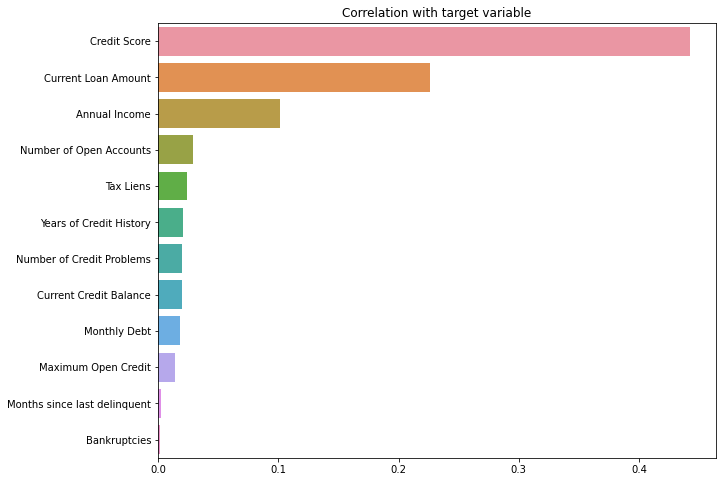

In [385]:
corr_with_target = np.abs(df.corr().iloc[:-1, -1]).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

In [386]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [387]:
# взглянем на целевую переменную
df[TARGET_NAME].value_counts() 

0    5387
1    2113
Name: Credit Default, dtype: int64

Наблюдается несбалансированность классов целевой переменной. Целевой класс (просточка кредита) встречается в 2,5 раза реже нецелевого.

In [388]:
# поиск дубликатов, из-за дубликатов в том числе может возникать несбалансированность
df.duplicated().unique() # array([False]) дубликатов не обнаружено

array([False])

In [389]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


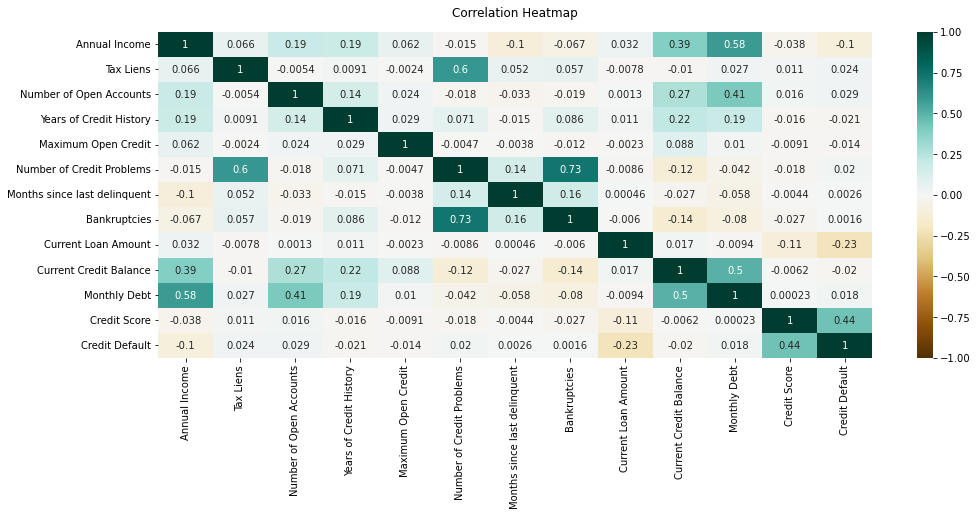

In [390]:
plt.figure(figsize=(16, 6))
 
# чтобы отобразить числовые значения корреляции на тепловой карте установим значение vmin=-1, vmax=1, annot=True. 
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG') 

# Параметр pad (padding) определяет расстояние заголовка от верхней части тепловой карты. 
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=15);

Наблюдаем корреляцию между количеством проблем с кредитами 'Numbers of Credit Problems' и банкротством 'Bankruptcies', возможно стоит их объединить в новом признаке

In [391]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [392]:
# просмотрим категориальные признаки
for cat_col in df.select_dtypes(include='object').columns:
    print(str(cat_col) + '\n\n' + str(df[cat_col].value_counts()) + '\n\n' + 100 * '*' + '\n\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

****************************************************************************************************


Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

****************************************************************************************************


Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacati

Объединим наличие кредитов на ипотеку и дом в ипотеке.

In [393]:
df.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
df['Home Ownership'].value_counts()

Home Mortgage    3649
Rent             3204
Own Home          647
Name: Home Ownership, dtype: int64

Объединим схожие цели кредитов.

In [394]:
# путешествия и отдых
df.loc[df['Purpose'] == 'vacation', 'Purpose'] = 'take a trip' 
# малый бизнес и заем на бизнес
df.loc[df['Purpose'] == 'small business', 'Purpose'] = 'business loan'
# возобновляемая энергия и прочее
df.loc[df['Purpose'] == 'renewable energy', 'Purpose'] = 'other'
df['Purpose'].value_counts()

debt consolidation      5944
other                    667
home improvements        412
business loan            155
buy a car                 96
medical bills             71
take a trip               45
major purchase            40
buy house                 34
wedding                   15
moving                    11
educational expenses      10
Name: Purpose, dtype: int64

Хочется признак 'Years in current job' сделать некатегориальным

In [395]:
dict_years_in_current_job = {'nan': np.NaN, 
                             '< 1 year': 0.5,
                             '1 year': 1,
                             '2 years': 2,
                             '3 years': 3,
                             '4 years': 4,
                             '5 years': 5,
                             '6 years': 6,
                             '7 years': 7,
                             '8 years': 8,
                             '9 years': 9,
                             '10+ years': 10}

df['Years in current job'].replace(dict_years_in_current_job, inplace=True)
df['Years in current job'].value_counts()

10.0    2332
2.0      705
3.0      620
0.5      563
5.0      516
1.0      504
4.0      469
6.0      426
7.0      396
8.0      339
9.0      259
Name: Years in current job, dtype: int64

In [396]:
df['Years in current job'].dtypes

dtype('float64')

### 2. Создание новых признаков<a class="anchor" id="gaps"></a>

In [397]:
# добавим индикатор к пропущенным значениям
mi = MissingIndicator()
mi.fit_transform(df)

# вывод фичей с пропущенными значениями
mi.get_feature_names_out()

array(['missingindicator_Annual Income',
       'missingindicator_Years in current job',
       'missingindicator_Months since last delinquent',
       'missingindicator_Bankruptcies', 'missingindicator_Credit Score'],
      dtype=object)

Введем новую фичу 'Annual Income Unknown' (годовой доход известный - 0, годовой доход неизвестный - 1)

In [398]:
df['Annual Income Unknown'] = 0
df.loc[(df['Annual Income'].isnull()), 'Annual Income Unknown'] = 1

Введем новую фичу 'Bad Background' (0 - проблем не было, 1 - небольшие проблемы, 2 - проблемы и банкротства)

In [399]:
df['Bad Background'] = True
df.loc[df['Number of Credit Problems'] > 0 , 'Bad Background'] = 1
df.loc[df['Bankruptcies'] > 0 , 'Bad Background'] = 2
df.loc[df['Number of Credit Problems'] == 0, 'Bad Background'] = 0
df['Bad Background'] = df['Bad Background'].astype(np.int8)
df['Bad Background'].value_counts()

0    6469
2     826
1     205
Name: Bad Background, dtype: int64

In [400]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job            float64
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
Annual Income Unknown             int64
Bad Background                     int8
dtype: object

In [401]:
for cat_colname in df.select_dtypes(include='object').columns[1:]:
    df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Annual Income Unknown',
       'Bad Background', 'Purpose_business loan', 'Purpose_buy a car',
       'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
       'Purpose_other', 'Purpose_take a trip', 'Purpose_wedding',
       'Term_Long Term', 'Term_Short Term'],
      dtype='object')

### 3. Обработка пропусков<a class="anchor" id="gaps"></a>

In [402]:
len(df) - df.count()  

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
Annual Income Unknown              0
Bad Background                     0
Purpose_business loan              0
Purpose_buy a car                  0
Purpose_buy house                  0
Purpose_debt consolidation         0
Purpose_educational expenses       0
Purpose_home improvements          0
Purpose_major purchase             0
Purpose_medical bills              0
P

In [403]:
df['Years in current job'].fillna(0, inplace=True) # заполняем пропуски 0 нулем, так как мы стараемся минимизировать риски при выдаче кредитов
df['Years in current job'].value_counts()

10.0    2332
2.0      705
3.0      620
0.5      563
5.0      516
1.0      504
4.0      469
6.0      426
7.0      396
0.0      371
8.0      339
9.0      259
Name: Years in current job, dtype: int64

In [404]:
df['Months since last delinquent'].value_counts()
df['Months since last delinquent'].isna().sum() # количество объектов с nan - месяцев просрочки

4081

In [405]:
df[df['Months since last delinquent'] == 0].count().sum()

575

Заполняем nan-месяцев просрочки нулями, так как полагаем, глядя на данные (очень большой процент пропусков, при этом объектов с 0 месяцев просрочки ничтожно мало), что у этих объектов просрочек не было.

In [406]:
df.loc[:, 'Months since last delinquent'].fillna(0, inplace=True) 
df['Months since last delinquent'].unique()


array([  0.,  73.,  18.,   6.,  40.,  44.,  45.,  17.,  61.,  14.,  11.,
        32.,  75.,  65.,  10.,  28.,  35.,  29.,  13.,   8.,  71.,  54.,
        21.,  68.,  51.,  70.,  19.,  22.,  16.,  38.,  36.,  34.,  30.,
         3.,  52.,  72.,  63.,  23.,   5.,  60.,  59.,   1.,  74.,   4.,
        42.,  39.,  41.,  55.,  67.,  37.,  47.,  26.,  76.,  43.,  12.,
         7.,  77.,  48.,  79.,  80.,  31.,  64.,  78.,  20.,  58.,  49.,
         9.,  69.,  25.,  33.,  15.,  57.,  86.,  62.,   2.,  24.,  56.,
        82.,  66.,  46.,  27.,  50.,  53.,  81.,  83., 118.,  84.,  91.,
        92.])

In [407]:
df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [408]:
df['Bankruptcies'].describe()

count    7486.000000
mean        0.117152
std         0.347192
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64

In [409]:
bankruptcies_mode = int(df['Bankruptcies'].mode())
bankruptcies_mode

0

In [410]:
df.loc[:, 'Bankruptcies'].fillna(bankruptcies_mode, inplace=True)

In [411]:
df.loc[df['Bankruptcies'] > 1, 'Bankruptcies'] = 2
df['Bankruptcies'].value_counts()

0.0    6674
1.0     786
2.0      40
Name: Bankruptcies, dtype: int64

Заполняем пропуски доходов на основе к-ближайших соседей, по матрице корреляции видим, что наибольшая зависимость 'Annual income' от 'Current Credit Balance' и 'Monthly Debt'

In [412]:
df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job               0
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                       0
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
Annual Income Unknown              0
Bad Background                     0
Purpose_business loan              0
Purpose_buy a car                  0
Purpose_buy house                  0
Purpose_debt consolidation         0
Purpose_educational expenses       0
Purpose_home improvements          0
Purpose_major purchase             0
Purpose_medical bills              0
P

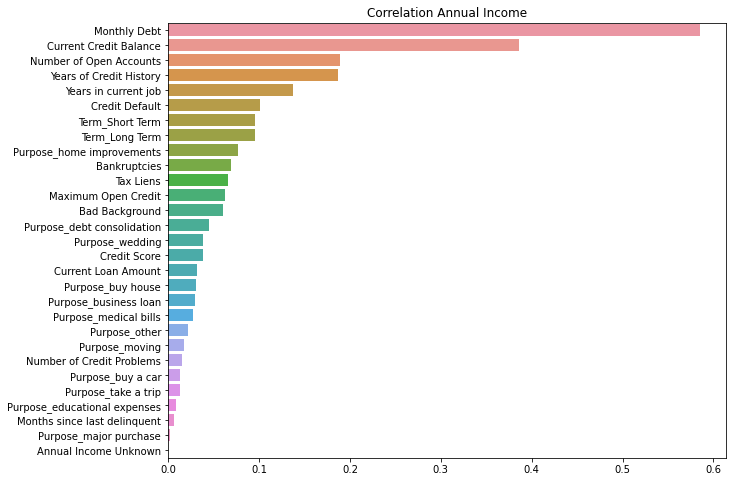

In [413]:
# корреляция признаков с 'Annual Income'
FEATURES = df.columns.drop('Annual Income').tolist()
corr_Annual_Income = np.abs(df[FEATURES + ['Annual Income']].corr().iloc[:-1, -1]).sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_Annual_Income.values, y=corr_Annual_Income.index)

plt.title('Correlation Annual Income')
plt.show()

In [414]:
knn = KNNImputer(n_neighbors=3) # ориентируемся на трех ближайших соседей
knn.fit(df[['Annual Income', 'Current Credit Balance', 'Monthly Debt', 'Current Loan Amount']])

KNNImputer(n_neighbors=3)

In [415]:
%%time
data_ = knn.transform(df[['Annual Income', 'Current Credit Balance', 'Monthly Debt', 'Current Loan Amount']])
data_

CPU times: user 941 ms, sys: 564 ms, total: 1.5 s
Wall time: 329 ms


array([[4.8208700e+05, 4.7386000e+04, 7.9140000e+03, 9.9999999e+07],
       [1.0254870e+06, 3.9497200e+05, 1.8373000e+04, 2.6496800e+05],
       [7.5141200e+05, 3.0838900e+05, 1.3651000e+04, 9.9999999e+07],
       ...,
       [1.8789100e+06, 4.7781200e+05, 1.2479000e+04, 9.9999999e+07],
       [1.5626740e+06, 4.7606400e+05, 3.7118000e+04, 6.1527400e+05],
       [1.0244040e+06, 2.8819200e+05, 9.0610000e+03, 2.6928000e+04]])

In [416]:
df[['Annual Income', 'Current Credit Balance', 'Monthly Debt', 'Current Loan Amount']] = data_

In [417]:
shapiro(df['Annual Income'])

ShapiroResult(statistic=0.7802829742431641, pvalue=0.0)

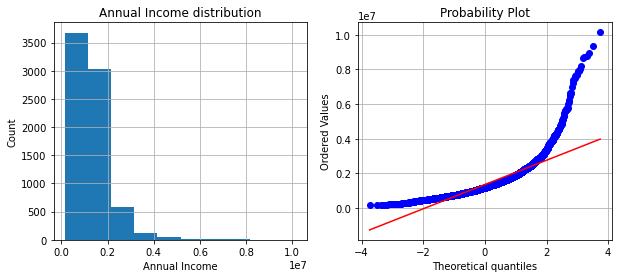

In [418]:
plt.figure(figsize=(10,4))

ax1 = plt.subplot(121)
ax1.set_xlabel('Annual Income')
ax1.set_ylabel('Count')
ax1.set_title(f'Annual Income distribution')
df['Annual Income'].hist()

plt.subplot(122)
probplot(df['Annual Income'], dist='norm', plot=plt)
plt.grid(True)

plt.show()

Закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака в группах с просроченным и непросроченным платежом, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

In [419]:
Annual_Income_with_target_s = df[['Annual Income', 'Credit Default']]
Annual_Income_target_0 = df.loc[df['Credit Default'] == 0, ['Annual Income']]
Annual_Income_target_1 = df.loc[df['Credit Default'] == 1, ['Annual Income']]

In [420]:
mannwhitneyu(Annual_Income_target_0, Annual_Income_target_1)

MannwhitneyuResult(statistic=array([6241472.]), pvalue=array([6.95611107e-11]))

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

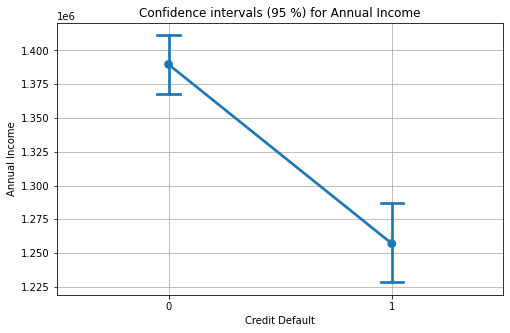

In [421]:
plt.figure(figsize=(8, 5))
sns.pointplot(x=TARGET_NAME, y='Annual Income', data=Annual_Income_with_target_s, capsize=.1)
plt.title('Confidence intervals (95 %) for Annual Income')
plt.grid(True)
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.
Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения.

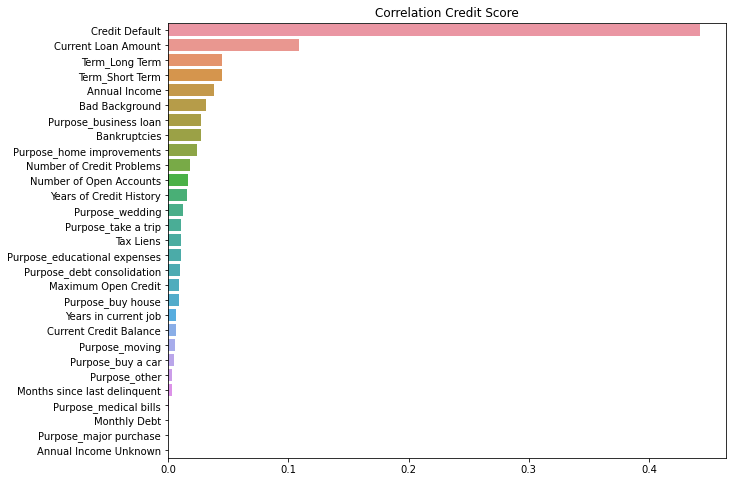

In [422]:
# корреляция признаков с 'Credit Score'
FEATURES = df.columns.drop('Credit Score').tolist()
corr_Credit_Score = np.abs(df[FEATURES + ['Credit Score']].corr().iloc[:-1, -1]).sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_Credit_Score.values, y=corr_Credit_Score.index)

plt.title('Correlation Credit Score')
plt.show()

In [423]:
knn = KNNImputer(n_neighbors=3) # ориентируемся на трех ближайших соседей
knn.fit(df[['Credit Score', 'Current Loan Amount', 'Annual Income', 'Term_Long Term']])
data_ = knn.transform(df[['Credit Score', 'Current Loan Amount', 'Annual Income', 'Term_Long Term']])
df[['Credit Score', 'Current Loan Amount', 'Annual Income', 'Term_Long Term']] = data_

### 4. Обработка выбросов<a class="anchor" id="outliers"></a>

In [424]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,7500.0,1.352293e+06,7.941416e+05,164597.0,859294.0,1.175862e+06,1616534.25,1.014934e+07
Years in current job,7500.0,5.627000e+00,3.698720e+00,0.0,2.0,6.000000e+00,10.00,1.000000e+01
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.000000e+00,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,1.000000e+01,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,1.700000e+01,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,4.781590e+05,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.000000e+00,0.00,7.000000e+00
Months since last delinquent,7500.0,1.581520e+01,2.264944e+01,0.0,0.0,0.000000e+00,29.00,1.180000e+02
Bankruptcies,7500.0,1.154667e-01,3.358807e-01,0.0,0.0,0.000000e+00,0.00,2.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,3.095730e+05,519882.00,1.000000e+08


In [425]:
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Annual Income Unknown',
       'Bad Background', 'Purpose_business loan', 'Purpose_buy a car',
       'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
       'Purpose_other', 'Purpose_take a trip', 'Purpose_wedding',
       'Term_Long Term', 'Term_Short Term'],
      dtype='object')

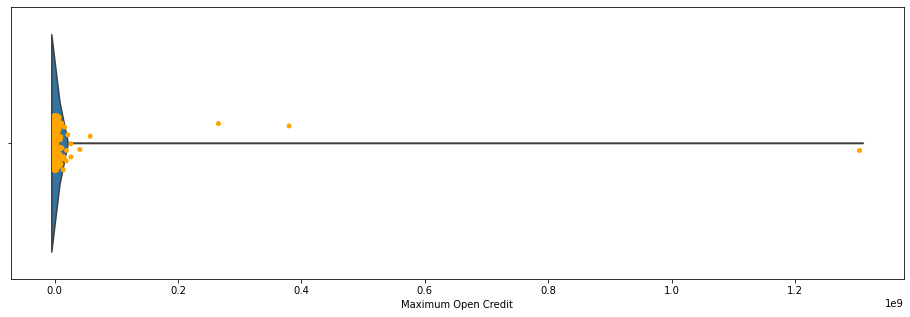

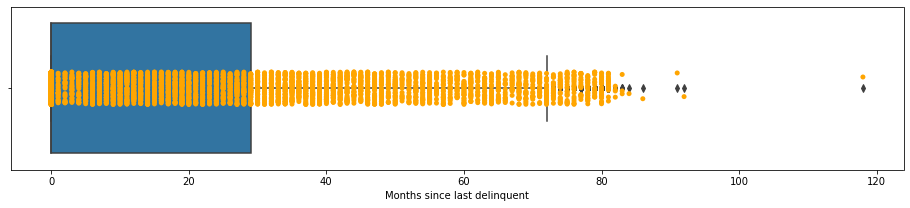

In [426]:
plt.figure(figsize=(16, 5))
sns.violinplot(df['Maximum Open Credit'])
sns.stripplot(df['Maximum Open Credit'], color='orange')
plt.show()

plt.figure(figsize=(16, 3))
sns.boxplot(df['Months since last delinquent'])
sns.stripplot(df['Months since last delinquent'], color='orange')
plt.show()

In [427]:
Maximum_Open_Credit_max_value = np.quantile(df['Maximum Open Credit'], q = 0.95)
print(f'Maximum_Open_Credit_max_value = {Maximum_Open_Credit_max_value}')
# df.loc[(df['Maximum Open Credit'] > Maximum_Open_Credit_max_value), 'Maximum Open Credit'].count()
df.loc[(df['Maximum Open Credit'] > Maximum_Open_Credit_max_value), 'Maximum Open Credit'] = Maximum_Open_Credit_max_value

Months_since_last_delinquent_max_value = np.quantile(df['Months since last delinquent'], q = 0.99)
print(f'Months_since_last_delinquent_max_value = {Months_since_last_delinquent_max_value}')
# df.loc[(df['Months since last delinquent'] > Months_since_last_delinquent_max_value), 'Months since last delinquent'].count()
df.loc[(df['Months since last delinquent'] > Months_since_last_delinquent_max_value), 'Months since last delinquent'] = Months_since_last_delinquent_max_value

Maximum_Open_Credit_max_value = 1706333.1999999997
Months_since_last_delinquent_max_value = 79.0


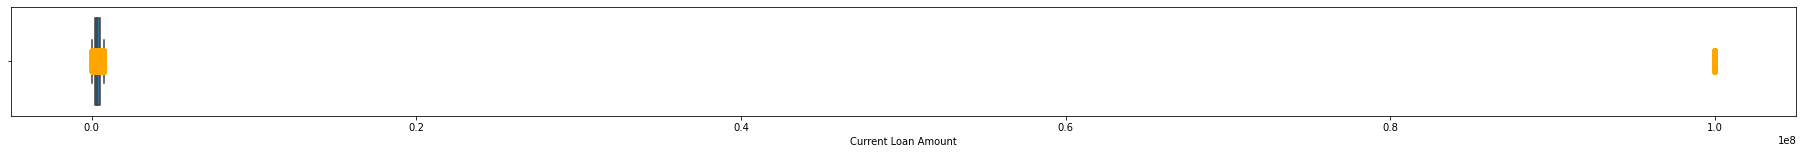

99999999.0    870
218064.0        6
89298.0         6
222926.0        5
265826.0        5
             ... 
351626.0        1
212498.0        1
187682.0        1
108922.0        1
26928.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [428]:
plt.figure(figsize=(32, 2))
sns.boxplot(df['Current Loan Amount'])
sns.stripplot(df['Current Loan Amount'], color='orange')
plt.show()

df['Current Loan Amount'].value_counts()

Замечаем, что выброс значительный (предположим, что текущая сумма кредита 'Current Loan Amount' велика, но неясно какая) и поэтому было решено ввести новый признак для данного выброса, а сам выброс в текущем признаке заполниить третьим квартилем (75м перцентилем)

In [429]:
# Вводим новый признак
df['Current Loan Amount Out'] = (df['Current Loan Amount'] == 99999999.0)

In [430]:
Current_Loan_Amount_max_value = np.quantile(df['Current Loan Amount'], q = 0.95) # (q = 0.95) = 99999999.0
Current_Loan_Amount_q75_value = np.quantile(df['Current Loan Amount'], q = 0.75)
print(f'Current_Loan_Amount_max_value = {Current_Loan_Amount_max_value}')
df.loc[(df['Current Loan Amount'] >= Current_Loan_Amount_max_value), 'Current Loan Amount'] = Current_Loan_Amount_q75_value

Current_Loan_Amount_max_value = 99999999.0


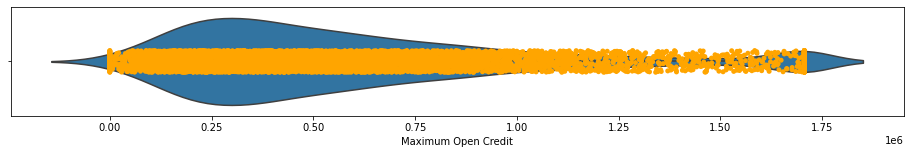

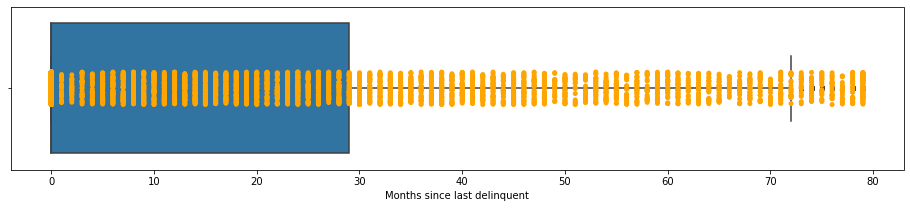

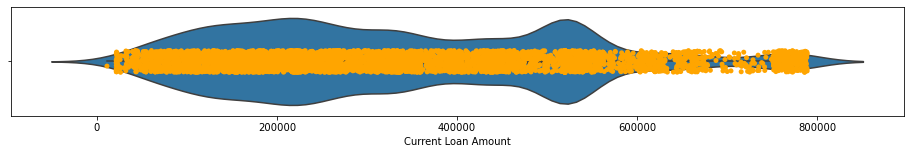

In [431]:
plt.figure(figsize=(16, 2))
sns.violinplot(df['Maximum Open Credit'])
sns.stripplot(df['Maximum Open Credit'], color='orange')
plt.show()

plt.figure(figsize=(16, 3))
sns.boxplot(df['Months since last delinquent'])
sns.stripplot(df['Months since last delinquent'], color='orange')
plt.show()

plt.figure(figsize=(16, 2))
sns.violinplot(df['Current Loan Amount'])
sns.stripplot(df['Current Loan Amount'], color='orange')
plt.show()

##### Нормализация данных

In [432]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

In [433]:
# Проведем балансировку по таргету
df = balance_df_by_target(data=df, target_name=TARGET_NAME, method='RandomOverSampler')

df[TARGET_NAME].value_counts()

0    5387
1    5387
Name: Credit Default, dtype: int64

In [434]:
df_train = transform(data = df_train)
df_test = transform(data = df_test)

In [435]:
# Проведем балансировку по таргету
df_train = balance_df_by_target(data=df_train, target_name=TARGET_NAME, method='RandomOverSampler')

In [436]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10774 entries, 10071 to 9646
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                10774 non-null  object 
 1   Annual Income                 10774 non-null  float64
 2   Years in current job          10774 non-null  float64
 3   Tax Liens                     10774 non-null  float64
 4   Number of Open Accounts       10774 non-null  float64
 5   Years of Credit History       10774 non-null  float64
 6   Maximum Open Credit           10774 non-null  float64
 7   Number of Credit Problems     10774 non-null  float64
 8   Months since last delinquent  10774 non-null  float64
 9   Bankruptcies                  10774 non-null  float64
 10  Purpose                       10774 non-null  object 
 11  Term                          10774 non-null  object 
 12  Current Loan Amount           10774 non-null  float64
 13

In [437]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   float64
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

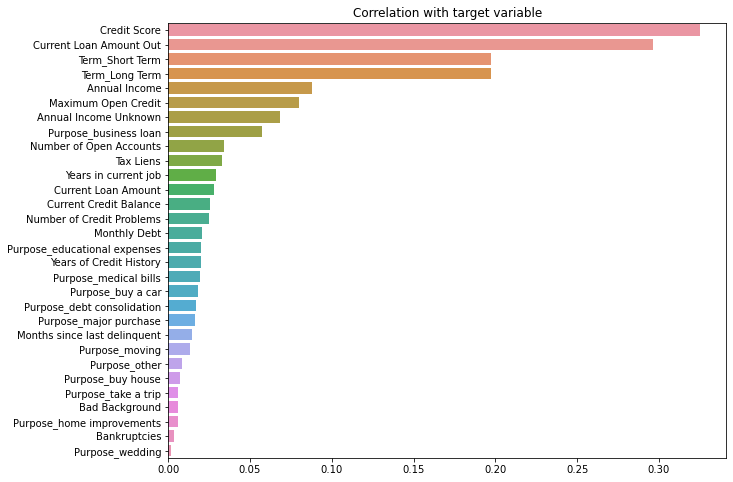

Credit Score                    0.324819
Current Loan Amount Out         0.296384
Term_Short Term                 0.197499
Term_Long Term                  0.197499
Annual Income                   0.087811
Maximum Open Credit             0.080140
Annual Income Unknown           0.068221
Purpose_business loan           0.057212
Number of Open Accounts         0.034107
Tax Liens                       0.032798
Years in current job            0.029209
Current Loan Amount             0.027893
Current Credit Balance          0.025554
Number of Credit Problems       0.024643
Monthly Debt                    0.020486
Purpose_educational expenses    0.020344
Years of Credit History         0.020030
Purpose_medical bills           0.019457
Purpose_buy a car               0.018347
Purpose_debt consolidation      0.017073
Purpose_major purchase          0.016388
Months since last delinquent    0.014774
Purpose_moving                  0.013368
Purpose_other                   0.008141
Purpose_buy hous

In [438]:
corr_with_target = np.abs(df.corr().iloc[:-1, -1]).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()


print(corr_with_target)

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [439]:
df_train = df_train.loc[:,~df_train.columns.duplicated()]
duplicate_columns = df_train.columns[df_train.columns.duplicated()]

In [440]:
SELECTED_FEATURE_NAMES = ['Credit Score', 'Current Loan Amount Out', 'Term_Long Term', 'Term_Short Term', 
                          'Annual Income', 'Maximum Open Credit', 'Annual Income Unknown', 'Purpose_business loan']

In [441]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]
# stratify для разбиения трайна и теста равномерно без перекосов в выборках
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21, stratify=y)

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

**Логистическая регрессия**

In [442]:
# model_lr = LogisticRegression()
# model_lr.fit(X_train, y_train)

# y_train_pred = model_lr.predict(X_train)
# y_test_pred = model_lr.predict(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
# print(f'\n\nf1_score = {f1_score(y_test, y_test_pred)}')

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.77      0.70      3771
           1       0.71      0.56      0.62      3770

    accuracy                           0.67      7541
   macro avg       0.67      0.67      0.66      7541
weighted avg       0.67      0.67      0.66      7541

TEST

              precision    recall  f1-score   support

           0       0.62      0.75      0.68      1616
           1       0.68      0.54      0.61      1617

    accuracy                           0.65      3233
   macro avg       0.65      0.65      0.64      3233
weighted avg       0.65      0.65      0.64      3233

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1208  408
1                736  881


f1_score = 0.6063317274604266


**k ближайших соседей**

In [443]:
# model_knn = KNeighborsClassifier()
# model_knn.fit(X_train, y_train)

# y_train_pred = model_knn.predict(X_train)
# y_test_pred = model_knn.predict(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

# print(f'\n\nf1_score = {f1_score(y_test, y_test_pred)}')

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.76      0.80      3771
           1       0.78      0.87      0.82      3770

    accuracy                           0.81      7541
   macro avg       0.82      0.81      0.81      7541
weighted avg       0.82      0.81      0.81      7541

TEST

              precision    recall  f1-score   support

           0       0.74      0.66      0.70      1616
           1       0.69      0.76      0.73      1617

    accuracy                           0.71      3233
   macro avg       0.72      0.71      0.71      3233
weighted avg       0.72      0.71      0.71      3233

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               1073   543
1                381  1236


f1_score = 0.7279151943462898


**Бустинговые алгоритмы**

*CatBoost*

In [444]:
# model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
# model_catb.fit(X_train, y_train)

# y_train_pred = model_catb.predict(X_train)
# y_test_pred = model_catb.predict(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
# print(f'\n\nf1_score = {f1_score(y_test, y_test_pred)}')

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      3771
           1       0.85      0.82      0.83      3770

    accuracy                           0.84      7541
   macro avg       0.84      0.84      0.84      7541
weighted avg       0.84      0.84      0.84      7541

TEST

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1616
           1       0.74      0.73      0.74      1617

    accuracy                           0.74      3233
   macro avg       0.74      0.74      0.74      3233
weighted avg       0.74      0.74      0.74      3233

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               1201   415
1                429  1188


f1_score = 0.737888198757764


*XGBoost*

In [445]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
print(f'\n\nf1_score = {f1_score(y_test, y_test_pred)}')

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      3771
           1       0.92      0.91      0.92      3770

    accuracy                           0.92      7541
   macro avg       0.92      0.92      0.92      7541
weighted avg       0.92      0.92      0.92      7541

TEST

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1616
           1       0.77      0.80      0.78      1617

    accuracy                           0.78      3233
   macro avg       0.78      0.78      0.78      3233
weighted avg       0.78      0.78      0.78      3233

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               1240   376
1                330  1287


f1_score = 0.7847560975609755


In [446]:
# model_lgbm = lgbm.LGBMClassifier(random_state=21)
# model_lgbm.fit(X_train, y_train)

# y_train_pred = model_lgbm.predict(X_train)
# y_test_pred = model_lgbm.predict(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

### Выбор лучшей модели и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

In [447]:
model_xgb = xgb.XGBClassifier(random_state=21)

**Подбор гиперпараметров**

In [448]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7, 9], 'min_child_weight':[1, 3, 6, 9]}

In [449]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [450]:
%%time

rs = RandomizedSearchCV(model_xgb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 47.7 s, sys: 10.3 s, total: 58 s
Wall time: 26.7 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=21,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7, 9],
                                        'min_child_weight': [1, 3, 6, 9],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [451]:
rs.best_params_

{'n_estimators': 1200, 'min_child_weight': 6, 'max_depth': 9}

In [452]:
rs.best_score_

0.8425159561870398

**Обучение и оценка финальной модели**

In [467]:
%%time

final_model = xgb.XGBClassifier(n_estimators=1200, min_child_weight=6, max_depth=9, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3771
           1       1.00      1.00      1.00      3770

    accuracy                           1.00      7541
   macro avg       1.00      1.00      1.00      7541
weighted avg       1.00      1.00      1.00      7541

TEST

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1616
           1       0.81      0.89      0.85      1617

    accuracy                           0.84      3233
   macro avg       0.84      0.84      0.84      3233
weighted avg       0.84      0.84      0.84      3233

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               1279   337
1                181  1436
CPU times: user 38.9 s, sys: 8.04 s, total: 46.9 s
Wall time: 8.94 s


### Снижение степени переобучения<a class="anchor" id="lowering_overfitting"></a>

In [468]:
%%time
# min_child_weight Используется для контроля переоборудования. Более высокие значения не позволяют модели 
# изучать отношения, которые могут быть очень специфичными для конкретной выборки, выбранной для дерева
final_model = xgb.XGBClassifier(n_estimators=1200, min_child_weight=30, max_depth=3, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3771
           1       0.87      0.87      0.87      3770

    accuracy                           0.87      7541
   macro avg       0.87      0.87      0.87      7541
weighted avg       0.87      0.87      0.87      7541

TEST

              precision    recall  f1-score   support

           0       0.75      0.76      0.76      1616
           1       0.76      0.75      0.75      1617

    accuracy                           0.75      3233
   macro avg       0.75      0.75      0.75      3233
weighted avg       0.75      0.75      0.75      3233

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               1228   388
1                406  1211
CPU times: user 16.4 s, sys: 2.79 s, total: 19.2 s
Wall time: 3.86 s


### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

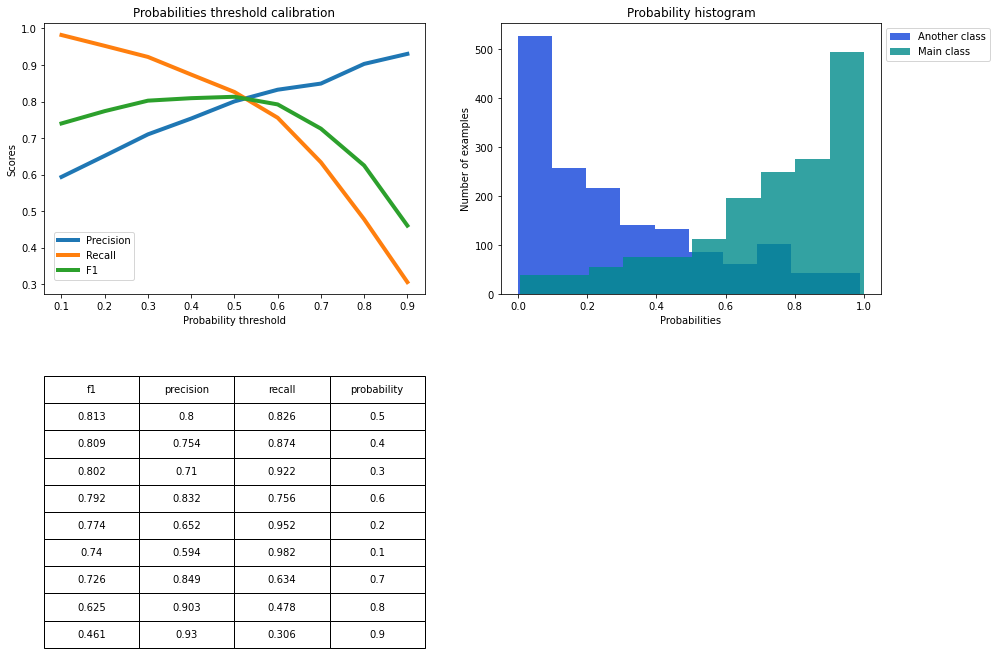

In [469]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков<a class="anchor" id="feature_importances"></a>

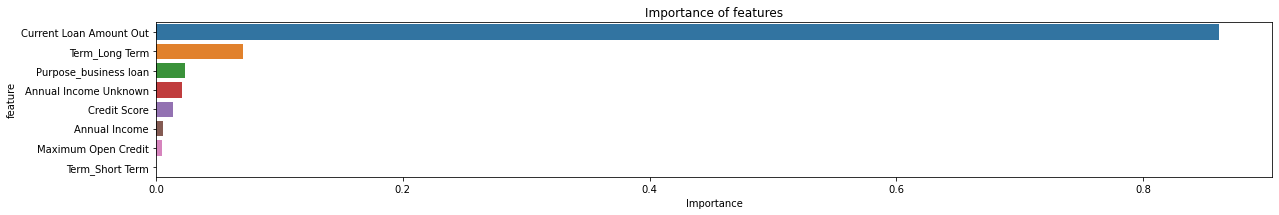

In [470]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

In [471]:
important_features_top

['Current Loan Amount Out',
 'Term_Long Term',
 'Purpose_business loan',
 'Annual Income Unknown',
 'Credit Score',
 'Annual Income',
 'Maximum Open Credit',
 'Term_Short Term']

### Финальная модель<a class="anchor" id="final_model"></a>

In [476]:
final_model = xgb.XGBClassifier(n_estimators=1200, min_child_weight=30, max_depth=3, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3771
           1       0.87      0.87      0.87      3770

    accuracy                           0.87      7541
   macro avg       0.87      0.87      0.87      7541
weighted avg       0.87      0.87      0.87      7541

TEST

              precision    recall  f1-score   support

           0       0.75      0.76      0.76      1616
           1       0.76      0.75      0.75      1617

    accuracy                           0.75      3233
   macro avg       0.75      0.75      0.75      3233
weighted avg       0.75      0.75      0.75      3233

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               1228   388
1                406  1211


In [477]:
print(f1_score(y_test, y_test_pred))

0.7531094527363185


In [481]:
y_pred = final_model.predict(df_test[important_features_top])
result=pd.DataFrame({'Id':np.arange(2500), 'Credit Default': y_pred})
result

,Id,Credit Default
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0
...,...,...
2495,2495,0
2496,2496,0
2497,2497,0
2498,2498,0


### Сохранение результатов<a class="anchor" id="final_model_saving"></a>

In [482]:
RESULT_PATH='./AVoroshilova_predictions.csv'
result.to_csv(RESULT_PATH, index=False)